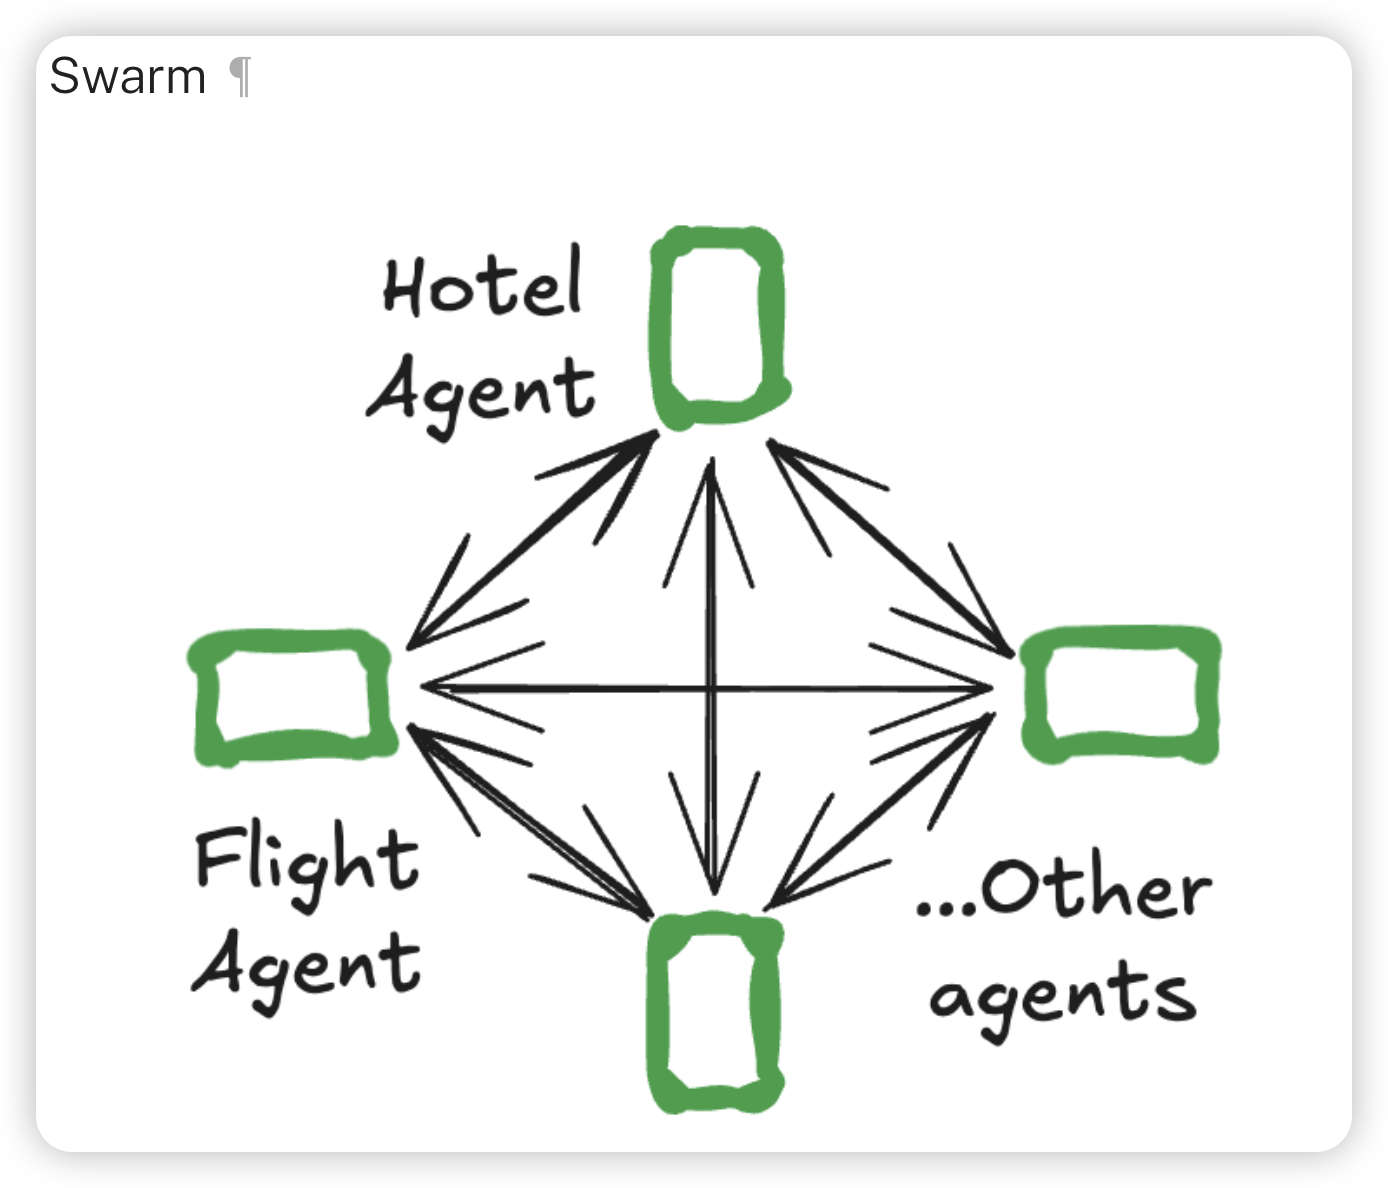

In [1]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph_swarm import create_swarm, create_handoff_tool

In [2]:
from dotenv import load_dotenv
import os
load_dotenv()

api_key = os.getenv("api_key")
base_url = os.getenv("base_url")

online_llm = ChatOpenAI(
    api_key=api_key,
    model="qwen-plus-latest",
    base_url=base_url,
    temperature=0
)

In [4]:

#定义工具
def book_hotel(hotel_name: str):
    """Book a hotel"""
    return f"Successfully booked a stay at {hotel_name}."

def book_flight(from_airport: str, to_airport: str):
    """Book a flight"""
    return f"Successfully booked a flight from {from_airport} to {to_airport}."


transfer_to_hotel_assistant = create_handoff_tool(
    agent_name="hotel_assistant",
    description="Transfer user to the hotel-booking assistant.",
)
transfer_to_flight_assistant = create_handoff_tool(
    agent_name="flight_assistant",
    description="Transfer user to the flight-booking assistant.",
)

In [5]:
#定义代理,即智能体

flight_assistant = create_react_agent(
    model=online_llm,
    tools=[book_flight, transfer_to_hotel_assistant],
    prompt="You are a flight booking assistant",
    name="flight_assistant"
)
hotel_assistant = create_react_agent(
    model=online_llm,
    tools=[book_hotel, transfer_to_flight_assistant],
    prompt="You are a hotel booking assistant",
    name="hotel_assistant"
)





In [14]:
hotel_assistant.invoke(
    {
    "messages":[
        {"role": "user", "content": "我想要预定一间亚朵的房间，大概住7天"},
    ]
    }
    )['messages'][-1]

AIMessage(content='您已经成功预定了亚朵酒店的房间，预订时长为7天。如有其他需求或问题，请随时告诉我！', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 268, 'total_tokens': 295, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen-plus-latest', 'system_fingerprint': None, 'id': 'chatcmpl-7f762819-38b1-9d8e-9b1b-c029885baaf0', 'finish_reason': 'stop', 'logprobs': None}, name='hotel_assistant', id='run-e56130d9-d3a5-48e9-b0b7-8a3a77b15790-0', usage_metadata={'input_tokens': 268, 'output_tokens': 27, 'total_tokens': 295, 'input_token_details': {}, 'output_token_details': {}})

In [6]:
#创建一个监督者，将智能体和模型组合在一起
swarm = create_swarm(
    agents=[flight_assistant, hotel_assistant],
    default_active_agent="flight_assistant"
).compile()

In [7]:
result = swarm.invoke({
        "messages": [
            {
                "role": "user",
                "content": "book a flight from BOS to JFK and a stay at McKittrick Hotel"
            }
        ]
    })

In [8]:
result['messages'][-1].content

"Your flight from BOS to JFK and your stay at the McKittrick Hotel have been successfully booked! Let me know if there's anything else I can assist you with."

In [9]:
for chunk in swarm.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "book a flight from BOS to JFK and a stay at McKittrick Hotel"
            }
        ]
    }
):
    print(chunk)
    print("\n")

{'flight_assistant': {'messages': [HumanMessage(content='book a flight from BOS to JFK and a stay at McKittrick Hotel', additional_kwargs={}, response_metadata={}, id='c6425476-9200-4b15-b17f-e7d290715567'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3da5975e698c4e50babafd', 'function': {'arguments': '{"from_airport": "BOS", "to_airport": "JFK"}', 'name': 'book_flight'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 238, 'total_tokens': 289, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'qwen-plus-latest', 'system_fingerprint': None, 'id': 'chatcmpl-a5306d7b-afb8-9240-837c-9bb181523685', 'finish_reason': 'tool_calls', 'logprobs': None}, name='flight_assistant', id='run-60fffe36-62d1-4ae4-a684-46fb5b580924-0', tool_calls=[{'name': 'book_flight', 'args': {'from_airport': 'BOS', 'to_airport': 'JFK'}, 'id': 'call_3da5975e698c4e50babafd', 'type': 't